In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import seaborn as sns
from sklearn.model_selection import ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFE
import statsmodels.api as sm
import catboost as ctb

%matplotlib inline

In [23]:
def fill_nan_with_median(df, param):
'''Функция для заполнения пропусков, в случае непрерывных параметров
df- датафрейм, param - параметр'''
    df.loc[df[param].isnull(), param] = df[param].median()

In [24]:
def fill_nan_with_mode(df, param):
'''Функция для заполнения пропусков, в случае дискретных параметров, категорий
df- датафрейм, param - параметр'''
    df[param].fillna(df[param].mode()[0], inplace=True)

In [37]:
def consolidate(df, param, old_cat, new_cat):
'''Функция для объединения нескольких категория в одну, в тех случаях, когда в категории мало наблюдений
df - датафрейм, param - параметр, old_cat - список старых значений категории, new_cat - категория, в которую объединяются 
малочисленные категории'''
    for i in old_cat:
        df.loc[df[param] == i, param] = new_cat

In [26]:
train_data = r"C:/Users/Nick/Desktop/course_project_train.csv"
test_data = r"C:/Users/Nick/Desktop/course_project_test.csv"

In [27]:
train_set = pd.read_csv(train_data)
test_set= pd.read_csv(test_data)

In [28]:
# Объединяю тренировочную и тестовую датасеты
new_data = pd.concat([train_set, test_set])
new_data = new_data.reset_index(drop=True)
new_data.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0.0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1.0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0.0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0.0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0.0


### Анализ данных ###

In [29]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                10000 non-null  object 
 1   Annual Income                 7930 non-null   float64
 2   Years in current job          9543 non-null   object 
 3   Tax Liens                     10000 non-null  float64
 4   Number of Open Accounts       10000 non-null  float64
 5   Years of Credit History       10000 non-null  float64
 6   Maximum Open Credit           10000 non-null  float64
 7   Number of Credit Problems     10000 non-null  float64
 8   Months since last delinquent  4561 non-null   float64
 9   Bankruptcies                  9983 non-null   float64
 10  Purpose                       10000 non-null  object 
 11  Term                          10000 non-null  object 
 12  Current Loan Amount           10000 non-null  float64
 13  Cu

In [30]:
new_data.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7.930000e+03,10000.000000,10000.00000,10000.000000,1.000000e+04,10000.00000,4561.000000,9983.000000,1.000000e+04,1.000000e+04,10000.000000,7930.000000,7500.000000
mean,1.366525e+06,0.031400,11.14430,18.319580,8.865079e+05,0.16800,34.564569,0.114595,1.194381e+07,2.914741e+05,18303.675600,1171.992182,0.281733
std,8.638276e+05,0.304341,4.89476,7.095357,1.389982e+07,0.51459,21.771990,0.349729,3.200878e+07,3.339979e+05,11831.647516,1639.812951,0.449874
min,1.065330e+05,0.000000,1.00000,3.900000,0.000000e+00,0.00000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.459892e+05,0.000000,8.00000,13.500000,2.788115e+05,0.00000,16.000000,0.000000,1.805485e+05,1.132258e+05,10059.750000,711.000000,0.000000
50%,1.168814e+06,0.000000,10.00000,17.000000,4.781810e+05,0.00000,32.000000,0.000000,3.117180e+05,2.090190e+05,16200.000000,731.000000,0.000000
75%,1.638693e+06,0.000000,14.00000,22.000000,7.943595e+05,0.00000,50.000000,0.000000,5.210700e+05,3.619500e+05,23888.250000,743.000000,1.000000
max,1.497561e+07,15.000000,48.00000,57.700000,1.304726e+09,15.00000,118.000000,5.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [31]:
features_cat = ['Home Ownership', 'Years in current job', 'Tax Liens', 'Number of Open Accounts',
               'Number of Credit Problems', 'Bankruptcies', 'Purpose', 'Term']
features_all = ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 
                'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
                'Bankruptcies', 'Purpose', 'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 
               'Credit Score']

In [32]:
# Просматриваю в категориальных параметрах сколько наблюдений сделано для каждой категории.
# Нужно стараться уходить от наличия категория с наблюдениями < 10, так как при разделении на фолды
# в один фолд могут попасть не все категории, что будет увеличивать переобучение
for i in features_cat:
    print (i, '\n', new_data[i].value_counts(), '\n\n')

Home Ownership 
 Home Mortgage    4862
Rent             4224
Own Home          895
Have Mortgage      19
Name: Home Ownership, dtype: int64 


Years in current job 
 10+ years    3142
2 years       917
3 years       848
< 1 year      770
5 years       685
1 year        657
4 years       621
6 years       563
7 years       536
8 years       446
9 years       358
Name: Years in current job, dtype: int64 


Tax Liens 
 0.0     9811
1.0      128
2.0       35
3.0       11
4.0        7
5.0        3
6.0        3
15.0       1
7.0        1
Name: Tax Liens, dtype: int64 


Number of Open Accounts 
 9.0     973
11.0    903
10.0    895
8.0     861
7.0     789
12.0    766
6.0     687
13.0    643
14.0    579
5.0     431
15.0    410
16.0    346
17.0    298
4.0     275
18.0    195
19.0    185
20.0    130
3.0     124
21.0    107
23.0     76
22.0     75
24.0     59
25.0     38
2.0      35
27.0     24
26.0     17
28.0     17
30.0     17
29.0     11
33.0      8
31.0      7
32.0      6
34.0      3
37.0    

In [33]:
# Вычисляю пропуски 
for i in features_all:
    print(i, ':', pd.isnull(new_data[i]).sum(), '\n')

Home Ownership : 0 

Annual Income : 2070 

Years in current job : 457 

Tax Liens : 0 

Number of Open Accounts : 0 

Years of Credit History : 0 

Maximum Open Credit : 0 

Number of Credit Problems : 0 

Months since last delinquent : 5439 

Bankruptcies : 17 

Purpose : 0 

Term : 0 

Current Loan Amount : 0 

Current Credit Balance : 0 

Monthly Debt : 0 

Credit Score : 2070 



### Заполнение пропущенных данных и объединение маленьких категорий

In [34]:
# Заменяю пропуски медианой или модой, в зависимости от типа параметра
fill_nan_with_median(new_data, 'Annual Income')
fill_nan_with_median(new_data, 'Months since last delinquent')
fill_nan_with_median(new_data, 'Credit Score')
fill_nan_with_median(new_data, 'Bankruptcies')
fill_nan_with_mode(new_data, 'Years in current job')

In [35]:
for i in features_all:
    print(i, ':', pd.isnull(new_data[i]).sum(), '\n')

Home Ownership : 0 

Annual Income : 0 

Years in current job : 0 

Tax Liens : 0 

Number of Open Accounts : 0 

Years of Credit History : 0 

Maximum Open Credit : 0 

Number of Credit Problems : 0 

Months since last delinquent : 0 

Bankruptcies : 0 

Purpose : 0 

Term : 0 

Current Loan Amount : 0 

Current Credit Balance : 0 

Monthly Debt : 0 

Credit Score : 0 



In [38]:
# Следующие шаги направлены на удаление категорий с маленьким количесвтом наблюдейний и объединение этих категорий
small_tax_liens = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 15.0]
consolidate(new_data, 'Tax Liens', small_tax_liens, 1)

In [39]:
new_data['Tax Liens'].value_counts()

0.0    9811
1.0     189
Name: Tax Liens, dtype: int64

In [40]:
small_account_number = [43.0, 41.0, 48.0, 38.0, 35.0, 36.0, 42.0, 1.0, 37.0, 34.0, 32.0, 31.0, 33.0, 
                       29.0, 30.0, 28.0, 26.0, 27.0, 2.0, 25.0, 24.0, 22.0, 23.0]
consolidate(new_data, 'Number of Open Accounts', small_account_number, 21)
new_data['Number of Open Accounts'].value_counts()

In [55]:
small_credit_problems = [3.0, 4.0, 5.0, 6.0, 7.0, 15.0]
consolidate(new_data, 'Number of Credit Problems', small_credit_problems, 2)
new_data['Number of Credit Problems'].value_counts()

0.0    8646
1.0    1162
2.0     192
Name: Number of Credit Problems, dtype: int64

In [59]:
small_bankruptcies = [2.0, 3.0, 4.0, 5.0]
consolidate(new_data, 'Bankruptcies', small_bankruptcies, 1)
new_data['Bankruptcies'].value_counts()

0.0    8929
1.0    1071
Name: Bankruptcies, dtype: int64

In [60]:
small_purpose = ['wedding', 'educational expenses', 'moving', 'vacation', 'renewable energy']
consolidate(new_data, 'Purpose', small_purpose, 'other')
new_data['Purpose'].value_counts()

debt consolidation    7917
other                  960
home improvements      552
business loan          159
buy a car              130
medical bills           98
buy house               53
take a trip             51
major purchase          49
small business          31
Name: Purpose, dtype: int64

### Новый параметр

In [61]:
# Создаю новый параметр, основанный на Annual Income. Суть в том, что я считаю сколько средств остается у клиента 
# (квартплата в зависимости от типа жилья и налоги, которые он платит)
new_data['new param'] = new_data['Home Ownership']

In [62]:
new_data.loc[new_data['new param'] == 'Home Mortgage', 'new param'] = new_data['Annual Income'] * 0.3 
new_data.loc[new_data['new param'] == 'Rent', 'new param'] = new_data['Annual Income'] * 0.2 
new_data.loc[new_data['new param'] == 'Own Home', 'new param'] = new_data['Annual Income'] * 0.003 
new_data.loc[new_data['new param'] == 'Have Mortgage', 'new param'] = new_data['Annual Income'] * 0.3

In [63]:
new_data['money tax liens'] = new_data['Tax Liens']
new_data.loc[new_data['money tax liens'] == 0, 'new param'] = new_data['Annual Income'] * 0.1
new_data.loc[new_data['money tax liens'] == 1, 'new param'] = new_data['Annual Income'] * 0.01

In [64]:
new_data['remaining money'] = new_data['Annual Income'] - (new_data['new param'] + new_data['money tax liens']
                                                          + new_data['Monthly Debt'])

In [65]:
new_data.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,new param,money tax liens,remaining money
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,32.0,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0.0,48208.7,0.0,425964
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,32.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1.0,102549,0.0,904565
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,32.0,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0.0,75141.2,0.0,662620
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,32.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0.0,80506.8,0.0,713223
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,32.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0.0,77626.4,0.0,691458


In [66]:
new_data = new_data.drop(['new param', 'money tax liens'], axis=1)

In [68]:
new_data.to_pickle(r"D:\GeekBrains\Pytho_libraries pt.2\new_data_1_classification.pkl")

In [69]:
new_data = pd.read_pickle(r"D:\GeekBrains\Pytho_libraries pt.2\new_data_1_classification.pkl")

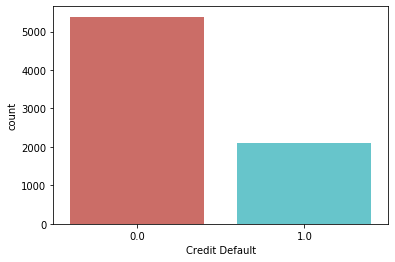

In [70]:
# Графически определяю насколько несбалансированны данные
sns.countplot(x='Credit Default', data=new_data, palette='hls')
plt.show()

In [71]:
# Уточняю насколько несбалансированны данные
no_default = len(new_data[new_data['Credit Default']==0])
yes_default = len(new_data[new_data['Credit Default']==1])
perc_of_no_default= no_default/(no_default+yes_default)
print("percentage of no default is", perc_of_no_default*100)
perc_yes_default = yes_default/(no_default+yes_default)
print("percentage yes default is", perc_yes_default*100)

percentage of no default is 71.82666666666667
percentage yes default is 28.173333333333332


### Выявление значимых параметров ###

Text(0, 0.5, 'Proportion of Defaults')

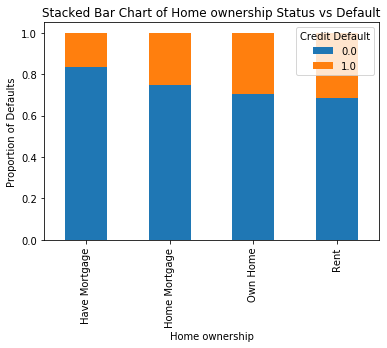

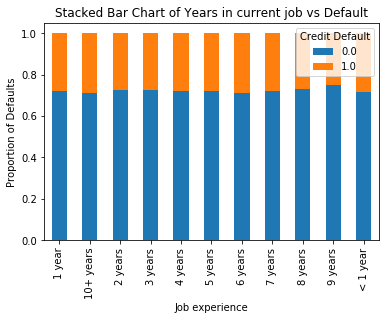

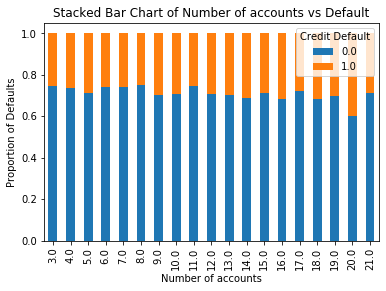

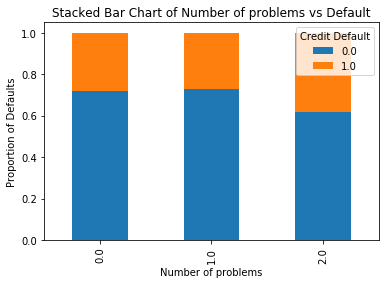

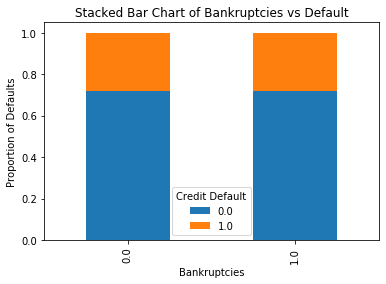

In [77]:
# Выявляю параметры, которые могут обладать наибольшей предсказательной способностью. Параметр, где гистаграмма
# будет сильно менятся в зависимости от категории, буду считать с хорошей предсказательной способностью

table_1=pd.crosstab(new_data['Home Ownership'], new_data['Credit Default'])
table_1.div(table_1.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Home ownership Status vs Default')
plt.xlabel('Home ownership')
plt.ylabel('Proportion of Defaults')

table_2=pd.crosstab(new_data['Years in current job'], new_data['Credit Default'])
table_2.div(table_2.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Years in current job vs Default')
plt.xlabel('Job experience')
plt.ylabel('Proportion of Defaults')

table_3=pd.crosstab(new_data['Number of Open Accounts'], new_data['Credit Default'])
table_3.div(table_3.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Number of accounts vs Default')
plt.xlabel('Number of accounts')
plt.ylabel('Proportion of Defaults')

table_4=pd.crosstab(new_data['Number of Credit Problems'], new_data['Credit Default'])
table_4.div(table_4.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Number of problems vs Default')
plt.xlabel('Number of problems')
plt.ylabel('Proportion of Defaults')

table_5=pd.crosstab(new_data['Bankruptcies'], new_data['Credit Default'])
table_5.div(table_5.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Bankruptcies vs Default')
plt.xlabel('Bankruptcies')
plt.ylabel('Proportion of Defaults')

In [80]:
# Удаляю два столбца - Years in current job, Bankruptcies, так как данные параметры имеют низкую предскательную способность

new_data = new_data.drop(['Years in current job', 'Bankruptcies'], axis=1)
new_data['remaining money'] = new_data['remaining money'].astype(float)
new_data['Tax Liens'] = new_data['Tax Liens'].astype(object)
new_data['Number of Open Accounts'] = new_data['Number of Open Accounts'].astype(object)
new_data['Number of Credit Problems'] = new_data['Number of Credit Problems'].astype(object)
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                10000 non-null  object 
 1   Annual Income                 10000 non-null  float64
 2   Tax Liens                     10000 non-null  object 
 3   Number of Open Accounts       10000 non-null  object 
 4   Years of Credit History       10000 non-null  float64
 5   Maximum Open Credit           10000 non-null  float64
 6   Number of Credit Problems     10000 non-null  object 
 7   Months since last delinquent  10000 non-null  float64
 8   Purpose                       10000 non-null  object 
 9   Term                          10000 non-null  object 
 10  Current Loan Amount           10000 non-null  float64
 11  Current Credit Balance        10000 non-null  float64
 12  Monthly Debt                  10000 non-null  float64
 13  Cr

In [81]:
new_data = pd.get_dummies(new_data, dtype=float)

In [82]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Annual Income                  10000 non-null  float64
 1   Years of Credit History        10000 non-null  float64
 2   Maximum Open Credit            10000 non-null  float64
 3   Months since last delinquent   10000 non-null  float64
 4   Current Loan Amount            10000 non-null  float64
 5   Current Credit Balance         10000 non-null  float64
 6   Monthly Debt                   10000 non-null  float64
 7   Credit Score                   10000 non-null  float64
 8   Credit Default                 7500 non-null   float64
 9   remaining money                10000 non-null  float64
 10  Home Ownership_Have Mortgage   10000 non-null  float64
 11  Home Ownership_Home Mortgage   10000 non-null  float64
 12  Home Ownership_Own Home        10000 non-null  

In [84]:
x = new_data[new_data['Credit Default'].notnull()]
x_homework = new_data[new_data['Credit Default'].isnull()]

y = pd.DataFrame(new_data[new_data['Credit Default'].notnull()], columns=['Credit Default'])

In [85]:
x = x.drop(['Credit Default'], axis=1)
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7500 entries, 0 to 7499
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Annual Income                  7500 non-null   float64
 1   Years of Credit History        7500 non-null   float64
 2   Maximum Open Credit            7500 non-null   float64
 3   Months since last delinquent   7500 non-null   float64
 4   Current Loan Amount            7500 non-null   float64
 5   Current Credit Balance         7500 non-null   float64
 6   Monthly Debt                   7500 non-null   float64
 7   Credit Score                   7500 non-null   float64
 8   remaining money                7500 non-null   float64
 9   Home Ownership_Have Mortgage   7500 non-null   float64
 10  Home Ownership_Home Mortgage   7500 non-null   float64
 11  Home Ownership_Own Home        7500 non-null   float64
 12  Home Ownership_Rent            7500 non-null   f

In [86]:
x_homework = x_homework.drop(['Credit Default'], axis=1)
x_homework.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 7500 to 9999
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Annual Income                  2500 non-null   float64
 1   Years of Credit History        2500 non-null   float64
 2   Maximum Open Credit            2500 non-null   float64
 3   Months since last delinquent   2500 non-null   float64
 4   Current Loan Amount            2500 non-null   float64
 5   Current Credit Balance         2500 non-null   float64
 6   Monthly Debt                   2500 non-null   float64
 7   Credit Score                   2500 non-null   float64
 8   remaining money                2500 non-null   float64
 9   Home Ownership_Have Mortgage   2500 non-null   float64
 10  Home Ownership_Home Mortgage   2500 non-null   float64
 11  Home Ownership_Own Home        2500 non-null   float64
 12  Home Ownership_Rent            2500 non-null 

In [87]:
ctb_model = ctb.CatBoostClassifier(n_estimators=300, learning_rate=0.035, class_weights=[1, 2.558], 
                                   max_depth=2, silent=True, random_state=21)
rfe = RFE(ctb_model, 20)

In [89]:
# Удаляю малозначимые параметры после применениея dummies
selector = RFE(estimator=ctb_model, n_features_to_select=20, step=1)
rfe = rfe.fit(x, y.values.ravel())
print(rfe.support_)

[ True  True  True  True  True  True  True  True  True False  True False
  True False False False False False False False  True False False False
 False False False False  True False False False  True False False False
  True  True False False  True False False False False  True False  True
  True]


In [92]:
cols = list(x.columns)
best_features = pd.Series(rfe.support_,index = cols)
new_features = best_features[best_features==False].index
print(new_features)

Index(['Home Ownership_Have Mortgage', 'Home Ownership_Own Home',
       'Tax Liens_0.0', 'Tax Liens_1.0', 'Number of Open Accounts_3.0',
       'Number of Open Accounts_4.0', 'Number of Open Accounts_5.0',
       'Number of Open Accounts_6.0', 'Number of Open Accounts_7.0',
       'Number of Open Accounts_9.0', 'Number of Open Accounts_10.0',
       'Number of Open Accounts_11.0', 'Number of Open Accounts_12.0',
       'Number of Open Accounts_13.0', 'Number of Open Accounts_14.0',
       'Number of Open Accounts_15.0', 'Number of Open Accounts_17.0',
       'Number of Open Accounts_18.0', 'Number of Open Accounts_19.0',
       'Number of Open Accounts_21.0', 'Number of Credit Problems_0.0',
       'Number of Credit Problems_1.0', 'Purpose_buy a car',
       'Purpose_buy house', 'Purpose_home improvements',
       'Purpose_major purchase', 'Purpose_medical bills', 'Purpose_other',
       'Purpose_take a trip'],
      dtype='object')


In [93]:
x = x.drop(['Home Ownership_Have Mortgage', 'Home Ownership_Own Home',
       'Tax Liens_0.0', 'Tax Liens_1.0', 'Number of Open Accounts_3.0',
       'Number of Open Accounts_4.0', 'Number of Open Accounts_5.0',
       'Number of Open Accounts_6.0', 'Number of Open Accounts_7.0',
       'Number of Open Accounts_9.0', 'Number of Open Accounts_10.0',
       'Number of Open Accounts_11.0', 'Number of Open Accounts_12.0',
       'Number of Open Accounts_13.0', 'Number of Open Accounts_14.0',
       'Number of Open Accounts_15.0', 'Number of Open Accounts_17.0',
       'Number of Open Accounts_18.0', 'Number of Open Accounts_19.0',
       'Number of Open Accounts_21.0', 'Number of Credit Problems_0.0',
       'Number of Credit Problems_1.0', 'Purpose_buy a car',
       'Purpose_buy house', 'Purpose_home improvements',
       'Purpose_major purchase', 'Purpose_medical bills', 'Purpose_other',
       'Purpose_take a trip'], 
           axis=1)
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7500 entries, 0 to 7499
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Annual Income                  7500 non-null   float64
 1   Years of Credit History        7500 non-null   float64
 2   Maximum Open Credit            7500 non-null   float64
 3   Months since last delinquent   7500 non-null   float64
 4   Current Loan Amount            7500 non-null   float64
 5   Current Credit Balance         7500 non-null   float64
 6   Monthly Debt                   7500 non-null   float64
 7   Credit Score                   7500 non-null   float64
 8   remaining money                7500 non-null   float64
 9   Home Ownership_Home Mortgage   7500 non-null   float64
 10  Home Ownership_Rent            7500 non-null   float64
 11  Number of Open Accounts_8.0    7500 non-null   float64
 12  Number of Open Accounts_16.0   7500 non-null   f

In [94]:
x_homework = x_homework.drop(['Home Ownership_Have Mortgage', 'Home Ownership_Own Home',
       'Tax Liens_0.0', 'Tax Liens_1.0', 'Number of Open Accounts_3.0',
       'Number of Open Accounts_4.0', 'Number of Open Accounts_5.0',
       'Number of Open Accounts_6.0', 'Number of Open Accounts_7.0',
       'Number of Open Accounts_9.0', 'Number of Open Accounts_10.0',
       'Number of Open Accounts_11.0', 'Number of Open Accounts_12.0',
       'Number of Open Accounts_13.0', 'Number of Open Accounts_14.0',
       'Number of Open Accounts_15.0', 'Number of Open Accounts_17.0',
       'Number of Open Accounts_18.0', 'Number of Open Accounts_19.0',
       'Number of Open Accounts_21.0', 'Number of Credit Problems_0.0',
       'Number of Credit Problems_1.0', 'Purpose_buy a car',
       'Purpose_buy house', 'Purpose_home improvements',
       'Purpose_major purchase', 'Purpose_medical bills', 'Purpose_other',
       'Purpose_take a trip'], 
           axis=1)
x_homework.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 7500 to 9999
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Annual Income                  2500 non-null   float64
 1   Years of Credit History        2500 non-null   float64
 2   Maximum Open Credit            2500 non-null   float64
 3   Months since last delinquent   2500 non-null   float64
 4   Current Loan Amount            2500 non-null   float64
 5   Current Credit Balance         2500 non-null   float64
 6   Monthly Debt                   2500 non-null   float64
 7   Credit Score                   2500 non-null   float64
 8   remaining money                2500 non-null   float64
 9   Home Ownership_Home Mortgage   2500 non-null   float64
 10  Home Ownership_Rent            2500 non-null   float64
 11  Number of Open Accounts_8.0    2500 non-null   float64
 12  Number of Open Accounts_16.0   2500 non-null 

In [100]:
# Удаляю параметры, у которых p > 0,05
logit_model=sm.Logit(y,x)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.460292
         Iterations 12
                               Results: Logit
Model:                   Logit                Pseudo R-squared:     0.226    
Dependent Variable:      Credit Default       AIC:                  6944.3845
Date:                    2020-11-12 14:20     BIC:                  7082.8377
No. Observations:        7500                 Log-Likelihood:       -3452.2  
Df Model:                19                   LL-Null:              -4459.4  
Df Residuals:            7480                 LLR p-value:          0.0000   
Converged:               1.0000               Scale:                1.0000   
No. Iterations:          12.0000                                             
-----------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------

In [102]:
x = x.drop(['Years of Credit History', 'Months since last delinquent', 'remaining money', 'Home Ownership_Home Mortgage',
          'Home Ownership_Rent', 'Number of Credit Problems_2.0', 'Purpose_small business'], axis=1)
x_homework = x_homework.drop(['Years of Credit History', 'Months since last delinquent', 'remaining money', 
                              'Home Ownership_Home Mortgage','Home Ownership_Rent', 'Number of Credit Problems_2.0', 
                              'Purpose_small business'], axis=1)

In [103]:
x.to_pickle(r"D:\GeekBrains\Pytho_libraries pt.2\x_classification_1.pkl")
y.to_pickle(r"D:\GeekBrains\Pytho_libraries pt.2\y_classification_1.pkl")
x_homework.to_pickle(r"D:\GeekBrains\Pytho_libraries pt.2\x_homework_classification_1.pkl")
y_homework.to_pickle(r"D:\GeekBrains\Pytho_libraries pt.2\y_homework_classification_1.pkl")

In [104]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True, random_state=21)

In [128]:
ctb_model = ctb.CatBoostClassifier(n_estimators=200, learning_rate=0.005, class_weights=[1, 2.549], 
                                   max_depth=4, silent=True, random_state=21)
ctb_model.fit(x_train, y_train)

In [129]:
y_pred_train = ctb_model.predict(x_train)
y_pred_test = ctb_model.predict(x_test)
f1_train = f1_score(y_train, y_pred_train)
prec_train = precision_score(y_train, y_pred_train)
rec_train = recall_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test)
rec_test = recall_score(y_test, y_pred_test)


print("f1_train: {} \nPrecision_train:  {} \nRecall_train:  {} \n\nf1_test: {} \nPrecision_test:  {} \nRecall_test:  {}".format(f1_train, prec_train, rec_train, 
                                                                f1_test, prec_test, rec_test))

f1_train: 0.5241660993873383 
Precision_train:  0.5277587388622345 
Recall_train:  0.5206220419202163 

f1_test: 0.5206349206349207 
Precision_test:  0.5239616613418531 
Recall_test:  0.5173501577287066


In [133]:
y_homework_pred = ctb_model.predict(x_homework)
predicted_data = pd.DataFrame(y_homework_pred, columns=['Credit Default'])

,Credit Default
0,0.0
1,1.0
2,1.0
3,0.0
4,0.0


In [134]:
predicted_data.to_csv(r"D:\GeekBrains\Pytho_libraries pt.2\Dzhalagoniya_predictions_classification.csv")